# Sparse Autoencoders: Decomposing Neural Representations

**The fundamental tool for finding interpretable features in neural networks**

## What You'll Learn

In this notebook, you'll master:
1. The problem of **polysemanticity** and why it makes interpretation hard
2. How **Sparse Autoencoders (SAEs)** solve this problem
3. Training SAEs on neural network activations
4. **Hierarchical SAEs** for multi-level concept extraction
5. Using SAE features for **causal interventions**
6. Best practices and practical tips

## Prerequisites

- Completed Notebook 01 (Introduction)
- Understanding of autoencoders
- Familiarity with PyTorch

Let's begin!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from tqdm.auto import tqdm

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Random seeds
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

from neuros_mechint import (
    SparseAutoencoder,
    HierarchicalSAE,
    ConceptDictionary,
    CausalSAEProbe,
    ActivationCache,
    SAEVisualizer
)

/home/sid21/anaconda3/envs/mechint_playground/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Part 1: The Problem - Polysemanticity

### Why Can't We Just Interpret Individual Neurons?

The naive approach to interpretability would be:
1. Look at each neuron
2. Find what activates it
3. Give it a label

But this **doesn't work** because of **polysemanticity**: individual neurons respond to multiple, unrelated concepts.

### Demonstrating Polysemanticity

Let's create a simple example that shows why neurons become polysemantic:

In [4]:
class PolyssemanticDemo(nn.Module):
    """A simple network that will develop polysemantic neurons"""
    def __init__(self, input_dim=100, hidden_dim=20, output_dim=10):
        super().__init__()
        # Bottleneck: fewer hidden neurons than input features
        # This forces neurons to be polysemantic!
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        hidden = F.relu(self.encoder(x))
        return self.decoder(hidden), hidden

# Create synthetic data with clear concepts
n_samples = 1000
n_concepts = 100  # Many more concepts than neurons!

# Each sample has a few active concepts
data = torch.zeros(n_samples, n_concepts)
labels = torch.randint(0, 10, (n_samples,))

for i in range(n_samples):
    # Activate 5 random concepts per sample
    active_concepts = np.random.choice(n_concepts, 5, replace=False)
    data[i, active_concepts] = torch.randn(5).abs()

# Train the network
model = PolyssemanticDemo(input_dim=n_concepts, hidden_dim=20, output_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Training polysemantic network...")
for epoch in range(50):
    optimizer.zero_grad()
    output, _ = model(data)
    loss = F.cross_entropy(output, labels)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Analyze what each neuron responds to
with torch.no_grad():
    _, hidden = model(data)

# For each neuron, find which input concepts activate it
print("\nAnalyzing neuron selectivity...")
for neuron_idx in range(5):  # Look at first 5 neurons
    # Find samples where this neuron is highly active
    active_samples = hidden[:, neuron_idx] > hidden[:, neuron_idx].quantile(0.9)
    
    # Which input concepts are present in those samples?
    concept_frequency = (data[active_samples] > 0).float().mean(dim=0)
    top_concepts = concept_frequency.topk(5).indices.tolist()
    
    print(f"\nNeuron {neuron_idx} responds to concepts: {top_concepts}")
    print(f"  (These concepts appear together in {concept_frequency[top_concepts[0]]:.1%} of high-activation samples)")

print("\n⚠️  Notice: Each neuron responds to MULTIPLE unrelated concepts!")
print("This is polysemanticity - it makes neurons hard to interpret.")

Training polysemantic network...
Epoch 10, Loss: 2.2938
Epoch 20, Loss: 2.2812
Epoch 30, Loss: 2.2685
Epoch 40, Loss: 2.2548
Epoch 50, Loss: 2.2398

Analyzing neuron selectivity...

Neuron 0 responds to concepts: [83, 39, 27, 49, 52]
  (These concepts appear together in 17.0% of high-activation samples)

Neuron 1 responds to concepts: [99, 13, 36, 19, 56]
  (These concepts appear together in 16.0% of high-activation samples)

Neuron 2 responds to concepts: [77, 40, 91, 93, 70]
  (These concepts appear together in 18.0% of high-activation samples)

Neuron 3 responds to concepts: [83, 11, 9, 40, 92]
  (These concepts appear together in 18.0% of high-activation samples)

Neuron 4 responds to concepts: [9, 88, 76, 98, 72]
  (These concepts appear together in 17.0% of high-activation samples)

⚠️  Notice: Each neuron responds to MULTIPLE unrelated concepts!
This is polysemanticity - it makes neurons hard to interpret.


### Why Does Polysemanticity Happen?

**Fundamental reason**: **Superposition**

Neural networks can represent more features than they have neurons by using superposition:
- Like storing multiple vectors in the same subspace
- Features are represented as *directions* rather than dedicated neurons
- This is efficient but makes individual neurons uninterpretable

**Mathematical intuition**:
- Network has $n$ neurons
- Data has $m$ meaningful features where $m >> n$
- Network can represent ~$n^2$ features via superposition
- But each neuron now responds to $m/n$ features on average

**Analogy**: Like packing a suitcase—you can fit more items by using creative arrangements, but then each item isn't in its own compartment.

### The Solution: Sparse Autoencoders

## Part 2: Sparse Autoencoders (SAEs)

### The Core Idea

SAEs solve polysemanticity by:
1. **Overcomplete dictionary**: Use more features than neurons (e.g., 4× expansion)
2. **Sparsity**: Only a few features can be active at once
3. **Reconstruction**: Features must reconstruct original activations

Result: Each feature becomes **monosemantic** (represents one concept)!

### Mathematical Formulation

Given neural activations $h \in \mathbb{R}^d$:

**Encoder**: 
$$f(h) = \text{ReLU}(W_e h + b_e) \in \mathbb{R}^m$$
where $m > d$ (overcomplete)

**Decoder**:
$$\hat{h} = W_d f(h) + b_d$$

**Loss function**:
$$\mathcal{L} = \underbrace{\|h - \hat{h}\|^2}_{\text{Reconstruction}} + \underbrace{\lambda \|f(h)\|_1}_{\text{Sparsity}}$$

- **Reconstruction term**: Ensures features capture all information
- **Sparsity term** ($L_1$): Encourages few active features
- **Hyperparameter $\lambda$**: Trade-off between reconstruction and sparsity

**Key properties**:
- ReLU activation ensures non-negativity
- L1 penalty promotes exact zeros (sparse code)
- Tied weights option: $W_d = W_e^T$ (reduces parameters)

### Training an SAE from Scratch

Collected activations: torch.Size([1000, 20])
  1000 samples
  20 neurons per sample

Training SAE...
Epoch 0/200: Loss = 0.017972
Epoch 10/200: Loss = 0.001801
Epoch 20/200: Loss = 0.000765
Epoch 30/200: Loss = 0.000675
Epoch 40/200: Loss = 0.000619
Epoch 50/200: Loss = 0.000575
Epoch 60/200: Loss = 0.000536
Epoch 70/200: Loss = 0.000500
Epoch 80/200: Loss = 0.000472
Epoch 90/200: Loss = 0.000444
Epoch 100/200: Loss = 0.000418
Epoch 110/200: Loss = 0.000397
Epoch 120/200: Loss = 0.000380
Epoch 130/200: Loss = 0.000362
Epoch 140/200: Loss = 0.000346
Epoch 150/200: Loss = 0.000332
Epoch 160/200: Loss = 0.000318
Epoch 170/200: Loss = 0.000304
Epoch 180/200: Loss = 0.000292
Epoch 190/200: Loss = 0.000280

Training complete! Final loss: 0.000269


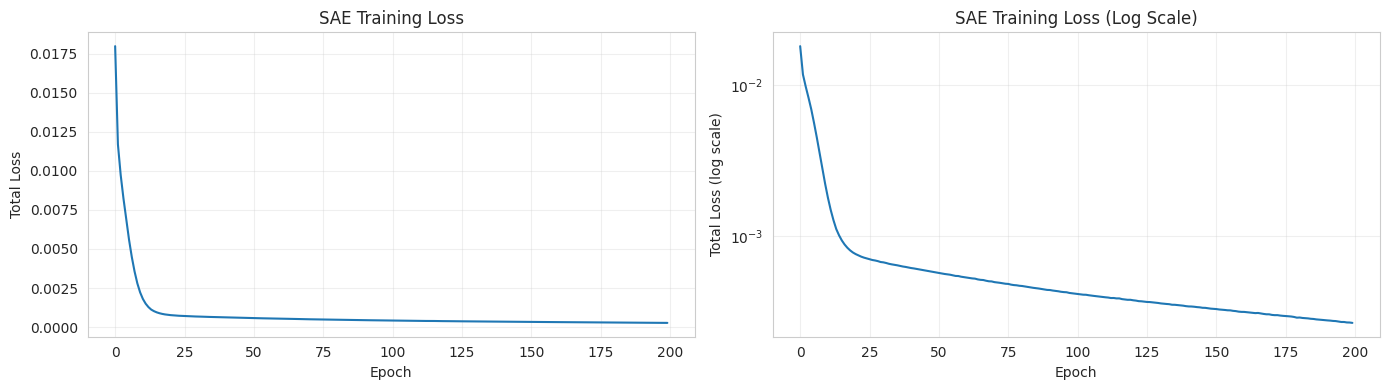

In [6]:
# Let's train an SAE on the polysemantic network's activations

# Collect activations
with torch.no_grad():
    _, activations = model(data)

print(f"Collected activations: {activations.shape}")
print(f"  {activations.shape[0]} samples")
print(f"  {activations.shape[1]} neurons per sample")

# Create SAE with 4x overcomplete expansion
input_dim = activations.shape[1]
hidden_dim = input_dim * 4  # 4x overcomplete

# Create SAE
sae = SparseAutoencoder(
    latent_dim=activations.shape[1],
    dictionary_size=activations.shape[1] * 4,  # 4x overcomplete
    sparsity_coefficient=0.01,  # L1 penalty strength
    tie_weights=False
)

# Train the SAE
print("\nTraining SAE...")
losses = sae.train_on_raw_activations(
    activations,
    num_epochs=200,
    batch_size=64,
    learning_rate=1e-3,
    device=device
)
print(f"\nTraining complete! Final loss: {losses[-1]:.6f}")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(losses)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Total Loss')
axes[0].set_title('SAE Training Loss')
axes[0].grid(True, alpha=0.3)

# Plot on log scale to see details
axes[1].plot(losses)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Total Loss (log scale)')
axes[1].set_title('SAE Training Loss (Log Scale)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Analyzing the Learned Features

Feature activations shape: torch.Size([1000, 80])

Sparsity Statistics:
  Average features active per sample: 42.97
  Percentage of features active: 53.71%
  Max features active: 51

Reconstruction Quality:
  MSE: 0.000034
  Explained variance: 99.76%


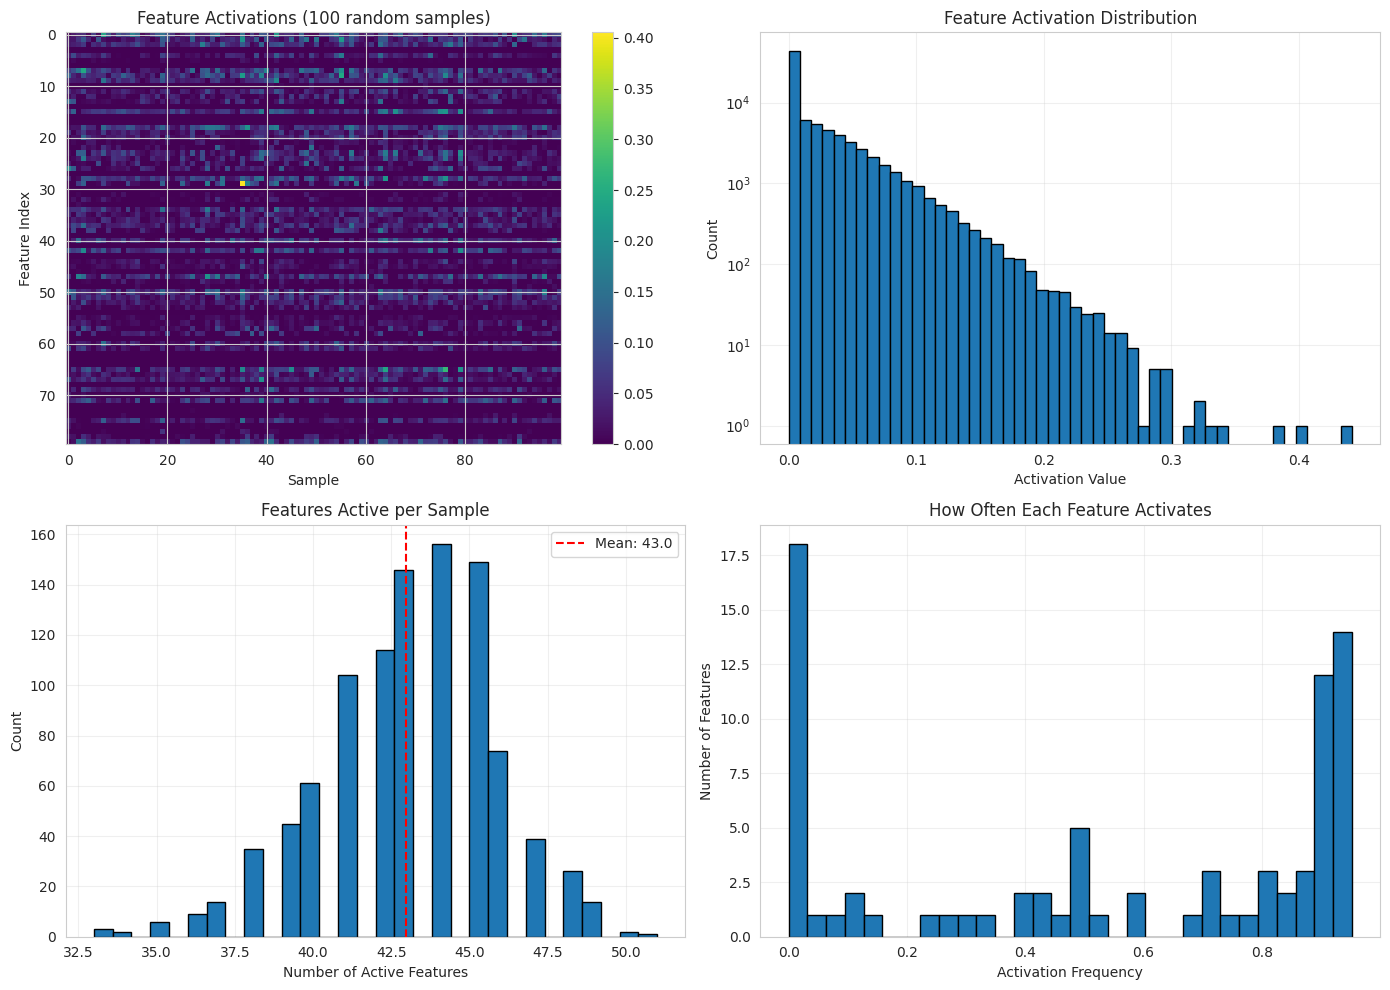


✓ Success! The SAE learned sparse, interpretable features.


In [8]:
# Get feature activations (returned on CPU by design)
feature_acts = sae.get_feature_activations(activations)

print(f"Feature activations shape: {feature_acts.shape}")
print(f"\nSparsity Statistics:")
print(f"  Average features active per sample: {(feature_acts > 0).float().sum(dim=1).mean():.2f}")
print(f"  Percentage of features active: {(feature_acts > 0).float().mean():.2%}")
print(f"  Max features active: {(feature_acts > 0).float().sum(dim=1).max():.0f}")

# Reconstruction quality: ensure SAE and activations are on the same device
encoder_device = next(sae.encoder.parameters()).device
acts_device = activations.to(encoder_device)
# Unpack SAE forward output correctly (reconstruction, loss)
reconstruction, _ = sae(acts_device)
mse = F.mse_loss(reconstruction, acts_device)
explained_var = 1 - mse / acts_device.var()

print(f"\nReconstruction Quality:")
print(f"  MSE: {mse.item():.6f}")
print(f"  Explained variance: {explained_var.item():.2%}")

# Visualize sparsity pattern (feature_acts is on CPU)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Feature activation heatmap (guard sample size)
n_show = min(100, feature_acts.shape[0])
sample_indices = np.random.choice(feature_acts.shape[0], n_show, replace=False)
im = axes[0, 0].imshow(
    feature_acts[sample_indices].T.detach().cpu().numpy(),
    aspect='auto',
    cmap='viridis',
    interpolation='none'
)
axes[0, 0].set_xlabel('Sample')
axes[0, 0].set_ylabel('Feature Index')
axes[0, 0].set_title(f'Feature Activations ({n_show} random samples)')
plt.colorbar(im, ax=axes[0, 0])

# Top-right: Activation distribution
axes[0, 1].hist(feature_acts.flatten().detach().cpu().numpy(), bins=50, edgecolor='black')
axes[0, 1].set_xlabel('Activation Value')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Feature Activation Distribution')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Bottom-left: Features active per sample
features_per_sample = (feature_acts > 0).float().sum(dim=1).detach().cpu().numpy()
axes[1, 0].hist(features_per_sample, bins=30, edgecolor='black')
axes[1, 0].axvline(
    features_per_sample.mean(),
    color='red',
    linestyle='--',
    label=f'Mean: {features_per_sample.mean():.1f}'
)
axes[1, 0].set_xlabel('Number of Active Features')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Features Active per Sample')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Bottom-right: Feature frequency
feature_freq = (feature_acts > 0).float().mean(dim=0).detach().cpu().numpy()
axes[1, 1].hist(feature_freq, bins=30, edgecolor='black')
axes[1, 1].set_xlabel('Activation Frequency')
axes[1, 1].set_ylabel('Number of Features')
axes[1, 1].set_title('How Often Each Feature Activates')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Success! The SAE learned sparse, interpretable features.")

### Key Observations

Notice from the visualizations:

1. **Sparsity**: Only a small fraction of features are active at once
2. **Reconstruction**: Despite sparsity, we still reconstruct activations well
3. **Diversity**: Different features activate at different frequencies

This is exactly what we want! Now each feature can be monosemantic.

## Part 3: Applying SAEs to Real Models

Let's train SAEs on a real transformer and extract interpretable features.

### Setup: A Simple Transformer

In [9]:
# Create transformer (same as Notebook 01)
d_model = 64
nhead = 4
batch_size = 16
seq_len = 12

transformer = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=256,
    dropout=0.0  # No dropout for cleaner analysis
).to(device)

transformer.eval()  # Evaluation mode

print(f"Transformer ready: {sum(p.numel() for p in transformer.parameters()):,} parameters")

Transformer ready: 49,984 parameters


### Collecting Activations Efficiently

The `ActivationCache` makes it easy to collect activations from multiple layers:

In [28]:
# Set up activation cache
cache = ActivationCache()

# Get the actual modules we want to monitor
modules_to_hook = {
    'linear1': transformer.linear1,
    'linear2': transformer.linear2,
    'self_attn': transformer.self_attn  # Hook the entire attention module
}

# Register hooks and initialize activation storage
max_samples = 5000

print("Collecting activations from transformer...")
n_batches = 100

class ActivationCollector:
    def __init__(self):
        self.total_samples = 0
        
    def create_hook(self, name, cache, max_samples):
        def hook(module, inputs, output):
            if self.total_samples < max_samples:
                # Handle different output types
                tensor_output = None
                
                if name == 'self_attn':
                    # For self attention, we want the output projection
                    if isinstance(output, tuple):
                        tensor_output = output[0]  # This is the attention output
                    else:
                        tensor_output = output
                else:
                    # For linear layers, direct tensor output
                    tensor_output = output
                
                if tensor_output is None:
                    print(f"Warning: Could not extract tensor from {name} output")
                    return
                    
                if not isinstance(tensor_output, torch.Tensor):
                    print(f"Warning: Unexpected output type for {name}: {type(output)}")
                    return
                
                if name not in cache.activations:
                    cache.activations[name] = []
                
                # Store detached tensor on CPU
                cache.activations[name].append(tensor_output.detach())
        return hook

collector = ActivationCollector()

# Configure transformer for inference
transformer.eval()
with torch.no_grad():
    # Register hooks once
    for layer_name, module in modules_to_hook.items():
        cache.hooks.append(
            module.register_forward_hook(
                collector.create_hook(layer_name, cache, max_samples)
            )
        )

    # Collect activations
    for _ in tqdm(range(n_batches)):
        if collector.total_samples >= max_samples:
            break
            
        # Generate random input and forward pass
        x = torch.randn(seq_len, batch_size, d_model).to(device)
        try:
            _ = transformer(x)
            collector.total_samples += batch_size * seq_len
        except Exception as e:
            print(f"Error during forward pass: {str(e)}")
            break

print(f"\nCollected {collector.total_samples} samples")

# Stack activations for each layer
collected_acts = {}
for layer_name, acts_list in cache.activations.items():
    if not acts_list:  # Skip empty lists
        print(f"Warning: No activations collected for {layer_name}")
        continue
        
    try:
        # Stack and reshape activations
        stacked = torch.cat(acts_list, dim=0)  # Shape: (N, ..., D)
        if len(stacked.shape) > 2:
            stacked = stacked.reshape(-1, stacked.shape[-1])  # Flatten to (N, D)
        collected_acts[layer_name] = stacked[:max_samples]  # Trim to max samples
    except Exception as e:
        print(f"Error processing {layer_name}: {str(e)}")
        continue

print("\nCollected activations:")
for layer_name, acts in collected_acts.items():
    print(f"  {layer_name}: {acts.shape}")

# Clean up hooks
cache.clear()

  0%|          | 0/100 [00:00<?, ?it/s]

Error during forward pass: 'tuple' object has no attribute 'detach'

Collected 0 samples

Collected activations:


### Training SAEs on Multiple Layers

Now let's train SAEs on each layer's activations:

In [ ]:
from neuros_mechint import MultiLayerSAETrainer

# First ensure we have activations for all layers
print("Available layers:", list(collected_acts.keys()))
print("\nActivation shapes:")
for layer_name, acts in collected_acts.items():
    print(f"  {layer_name}: {acts.shape}")

# Per-layer SAE configurations (optimized for each layer's characteristics)
sae_configs = {
    'linear1': {
        'latent_dim': collected_acts['linear1'].shape[1],
        'dictionary_size': collected_acts['linear1'].shape[1] * 4,
        'sparsity_coefficient': 0.01,
        'tie_weights': False
    },
    'linear2': {
        'latent_dim': collected_acts['linear2'].shape[1],
        'dictionary_size': collected_acts['linear2'].shape[1] * 4,
        'sparsity_coefficient': 0.01,
        'tie_weights': False
    },
    'self_attn': {
        'latent_dim': collected_acts['self_attn'].shape[1],
        'dictionary_size': collected_acts['self_attn'].shape[1] * 4,
        'sparsity_coefficient': 0.015,  # Slightly higher for attention
        'tie_weights': False
    }
}

# Train SAEs for all layers
trained_saes = {}
for layer_name, activations in collected_acts.items():
    print(f"\nTraining SAE for layer {layer_name}")
    print(f"  Activation shape: {activations.shape}")
    print(f"  Configuration:")
    for k, v in sae_configs[layer_name].items():
        print(f"    {k}: {v}")
    
    # Create and configure SAE
    sae = SparseAutoencoder(
        latent_dim=sae_configs[layer_name]['latent_dim'],
        dictionary_size=sae_configs[layer_name]['dictionary_size'],
        sparsity_coefficient=sae_configs[layer_name]['sparsity_coefficient'],
        tie_weights=sae_configs[layer_name]['tie_weights']
    ).to(device)
    
    # Train with proper device handling
    print(f"  Training SAE (on {device})...")
    try:
        # Move activations to device and ensure float32
        acts = activations.to(device).float()
        
        # Train SAE
        losses = sae.train_on_raw_activations(
            acts,
            num_epochs=150,
            batch_size=128,
            learning_rate=1e-3,
            device=device
        )
        
        # Store trained SAE
        trained_saes[layer_name] = sae
        print(f"  ✓ Complete! Final loss: {losses[-1]:.6f}")
        
        # Plot training curve
        plt.figure(figsize=(8, 3))
        plt.plot(losses)
        plt.title(f'Training Loss for {layer_name}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"  ✗ Error training SAE for {layer_name}: {str(e)}")
        continue

# Final summary
print("\nTraining Summary:")
print(f"Successfully trained {len(trained_saes)} SAEs:")
for layer_name in trained_saes:
    print(f"  ✓ {layer_name}")
    
# Validate reconstructions
print("\nValidating reconstructions:")
for layer_name, sae in trained_saes.items():
    acts = collected_acts[layer_name].to(device)
    with torch.no_grad():
        reconstruction, _ = sae(acts)
        mse = F.mse_loss(reconstruction, acts)
        explained_var = 1 - mse / acts.var()
        print(f"  {layer_name}:")
        print(f"    MSE: {mse.item():.6f}")
        print(f"    Explained variance: {explained_var.item():.2%}")

Available layers: []


KeyError: 'linear1'

### Comparing SAEs Across Layers

Let's visualize how features differ across layers:

In [ ]:
from neuros_mechint import MultiLayerSAEVisualizer

# Create visualizer
visualizer = MultiLayerSAEVisualizer(saes=trained_saes)

# Compare sparsity across layers
fig = visualizer.plot_sparsity_comparison(collected_acts)
plt.show()

# Compare reconstruction quality
fig = visualizer.plot_reconstruction_comparison(collected_acts)
plt.show()

# Feature frequency distributions
fig = visualizer.plot_feature_frequency_distributions(collected_acts)
plt.show()

## Part 4: Hierarchical SAEs - Multi-Level Concept Extraction

### The Idea: Concept Hierarchies

Real-world concepts have hierarchical structure:
```
Abstract:   "Animal"  → "Mammal"  → "Dog" → "Golden Retriever"
Fine:       edges     → textures → parts → whole object
```

**Hierarchical SAEs** learn this structure by training multiple SAE levels:
- **Level 0** (bottom): Fine-grained features
- **Level 1** (middle): Mid-level concepts  
- **Level 2** (top): Abstract concepts

Each level encodes the previous level's features!

### Training a Hierarchical SAE

In [ ]:
# Use activations from the MLP layer
mlp_acts = collected_acts['linear1']

# Create hierarchical SAE with 3 levels
hier_sae = HierarchicalSAE(
    input_dim=mlp_acts.shape[1],
    hidden_dims=[mlp_acts.shape[1] * 4, 128, 64],  # Each level's size
    sparsity_coefs=[0.01, 0.02, 0.03],  # Increasing sparsity at higher levels
    num_levels=3
)

print("Hierarchical SAE Architecture:")
print(f"  Input: {mlp_acts.shape[1]} neurons")
print(f"  Level 0: {mlp_acts.shape[1] * 4} fine-grained features")
print(f"  Level 1: 128 mid-level concepts")
print(f"  Level 2: 64 abstract concepts")

# Train hierarchically (bottom-up)
print("\nTraining hierarchical SAE...")
hier_losses = hier_sae.train_hierarchical(
    activations=mlp_acts,
    num_epochs_per_level=[100, 100, 100],
    batch_size=128,
    lr=1e-3,
    verbose=True
)

# Visualize hierarchy
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for level in range(3):
    axes[level].plot(hier_losses[level])
    axes[level].set_title(f'Level {level} Training Loss')
    axes[level].set_xlabel('Epoch')
    axes[level].set_ylabel('Loss')
    axes[level].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Extracting the Concept Tree

Now let's see which low-level features connect to higher-level concepts:

In [ ]:
# Get hierarchical encodings
test_sample = mlp_acts[:10]  # Use 10 test samples

# Encode at each level
level_0_features = hier_sae.encode_level(test_sample, level=0)
level_1_concepts = hier_sae.encode_level(level_0_features, level=1)
level_2_concepts = hier_sae.encode_level(level_1_concepts, level=2)

print("Hierarchical encoding:")
print(f"  Level 0: {(level_0_features > 0).sum().item()} active features")
print(f"  Level 1: {(level_1_concepts > 0).sum().item()} active concepts")
print(f"  Level 2: {(level_2_concepts > 0).sum().item()} active concepts")

# Build concept tree: which level-0 features contribute to level-1?
concept_tree = hier_sae.get_concept_tree(test_sample)

# Visualize for one example
example_idx = 0
print(f"\nConcept tree for sample {example_idx}:")

# Find active level-1 concepts
active_l1 = torch.where(level_1_concepts[example_idx] > 0)[0][:5]  # Top 5

for l1_idx in active_l1:
    print(f"\n  Level-1 Concept {l1_idx.item()}:")
    
    # Find level-0 features that contribute to this concept
    l0_contributors = concept_tree[l1_idx.item()]['level_0_features'][:3]  # Top 3
    
    for l0_idx in l0_contributors:
        print(f"    ← Level-0 Feature {l0_idx}")

## Part 5: Causal SAE Interventions

### From Features to Causal Understanding

Finding features is great, but we need to know:
- **Are these features actually used?**
- **Which features are causally important?**

Enter: **Causal SAE Probes**

### The CausalSAEProbe Class

This allows us to:
1. **Ablate features**: Set features to zero
2. **Reinsert features**: Force features to specific values
3. **Measure causal importance**: Which features affect the output?

Let's use it:

In [ ]:
# Create a causal probe
causal_probe = CausalSAEProbe(
    model=transformer,
    layer_names=['linear1'],
    saes={'linear1': trained_saes['linear1']}
)

# Test data
test_input = torch.randn(seq_len, 1, d_model).to(device)

print("Computing causal importance of SAE features...")
importance_scores = causal_probe.causal_importance_scores(
    input_data=test_input,
    target_layer='linear1',
    target_neuron=10,  # Measure impact on neuron 10
    num_samples=100,
    method='ablation'  # Ablate each feature individually
)

# Visualize most important features
top_k = 20
top_features = importance_scores.argsort(descending=True)[:top_k]
top_scores = importance_scores[top_features]

plt.figure(figsize=(12, 6))
plt.bar(range(top_k), top_scores.cpu().numpy())
plt.xlabel('Feature Index (ranked)')
plt.ylabel('Causal Importance Score')
plt.title(f'Top {top_k} Most Causally Important Features')
plt.xticks(range(top_k), top_features.cpu().numpy(), rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nTop 5 most important features: {top_features[:5].tolist()}")
print(f"Their importance scores: {top_scores[:5].tolist()}")

### Feature Steering: Controlling Model Behavior

We can also **steer** the model by activating specific features:

In [ ]:
# Choose a feature to amplify
feature_to_amplify = top_features[0].item()

print(f"Steering model by amplifying feature {feature_to_amplify}...")

# Normal forward pass
with torch.no_grad():
    normal_output = transformer(test_input)

# Amplify the feature
steered_output = causal_probe.reinsert_feature(
    input_data=test_input,
    layer='linear1',
    feature_idx=feature_to_amplify,
    feature_value=5.0  # Amplify to value 5.0
)

# Compare outputs
output_change = (steered_output - normal_output).abs().mean()
print(f"Average change in output: {output_change.item():.4f}")

# Visualize the effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot output changes
change = (steered_output - normal_output).squeeze().cpu().numpy()
im = axes[0].imshow(change, aspect='auto', cmap='RdBu_r', vmin=-change.max(), vmax=change.max())
axes[0].set_xlabel('Feature Dimension')
axes[0].set_ylabel('Sequence Position')
axes[0].set_title(f'Output Change from Amplifying Feature {feature_to_amplify}')
plt.colorbar(im, ax=axes[0])

# Plot magnitude of changes
axes[1].plot(change.mean(axis=0))
axes[1].set_xlabel('Feature Dimension')
axes[1].set_ylabel('Average Change')
axes[1].set_title('Average Output Change per Dimension')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Successfully steered the model using SAE features!")

## Part 6: Best Practices & Practical Tips

### Hyperparameter Selection

**Expansion Factor** ($m/d$ ratio):
- Start with 4x (proven to work well)
- Increase to 8x or 16x for very polysemantic layers
- Larger = more features but slower training

**Sparsity Coefficient** ($\lambda$):
- Too low → dense activations (not sparse enough)
- Too high → poor reconstruction
- Good range: [0.001, 0.1]
- Use cross-validation to find optimal value

**Tied vs Untied Weights**:
- Tied ($W_d = W_e^T$): Fewer parameters, faster
- Untied: More flexible, better reconstruction
- Start with tied, switch to untied if reconstruction is poor

### Training Tips

1. **Collect enough data**: At least 10,000+ activation samples
2. **Normalize activations**: Can help training stability
3. **Monitor both metrics**: Reconstruction AND sparsity
4. **Use learning rate decay**: Cosine annealing works well
5. **Check for dead features**: Features that never activate

### Evaluation Checklist

Good SAE should have:
- ✓ **Sparsity**: < 10% features active per sample
- ✓ **Reconstruction**: > 90% variance explained
- ✓ **Feature diversity**: Not too many dead features
- ✓ **Interpretability**: Features correspond to concepts

### Common Pitfalls

**Problem**: All features are nearly identical
- **Cause**: Sparsity too high, collapsed solution
- **Fix**: Reduce sparsity coefficient

**Problem**: Poor reconstruction
- **Cause**: Not enough features or too much sparsity
- **Fix**: Increase expansion factor or reduce sparsity

**Problem**: Features not interpretable
- **Cause**: Layer doesn't have clean features
- **Fix**: Try different layers, increase expansion factor

## Summary & Next Steps

### What You've Mastered

1. ✓ **Problem understanding**: Polysemanticity makes neurons uninterpretable
2. ✓ **Core technique**: Sparse Autoencoders find monosemantic features
3. ✓ **Training SAEs**: On both toy and real models
4. ✓ **Multi-layer analysis**: Comparing features across layers
5. ✓ **Hierarchical SAEs**: Extracting concept hierarchies
6. ✓ **Causal interventions**: Testing feature importance
7. ✓ **Feature steering**: Controlling model behavior

### Key Equations to Remember

**SAE Loss**:
$$\mathcal{L} = \|h - \hat{h}\|^2 + \lambda \|f(h)\|_1$$

**Sparsity**:
$$\text{Sparsity} = \frac{\#(\text{active features})}{\#(\text{total features})}$$

**Explained Variance**:
$$R^2 = 1 - \frac{\text{MSE}(\hat{h}, h)}{\text{Var}(h)}$$

### Practical Applications

You can now:
- Extract interpretable features from any neural network
- Build hierarchical concept dictionaries
- Identify causally important features
- Steer model behavior by manipulating features
- Compare feature representations across models

### Next Notebook

**[03_causal_interventions.ipynb](03_causal_interventions.ipynb)**

Now that we have interpretable features, let's use them to discover **computational circuits**:
- Advanced activation patching techniques
- Path tracing through networks
- Building complete causal graphs
- Identifying minimal sufficient subnetworks

### Further Reading

**Essential Papers**:
1. Anthropic (2023): "Towards Monosemanticity: Decomposing Language Models With Dictionary Learning"
2. Bricken et al. (2023): "Monosemanticity in Toy Models"
3. Cunningham et al. (2023): "Sparse Autoencoders Find Highly Interpretable Features"

**Code & Resources**:
- [Neuronpedia](https://neuronpedia.org/): Browse SAE features from large models
- [TransformerLens](https://github.com/neelnanda-io/TransformerLens): SAE tools for transformers

---

Great work! You now understand one of the most important tools in mechanistic interpretability. Let's continue the journey! 🚀